In [1]:
import yfinance as yf
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from ta.momentum import RSIIndicator
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LSTM,
    BatchNormalization,
    Bidirectional,
)
from tensorflow.keras.optimizers import Adam
import datetime
from matplotlib import pyplot as plt
import time

## Gathering the data


### Downloading the initial data


In [2]:
# The main ticker to predict
TICKER_TO_PREDICT = "SPY"
# Supplementary tickers to help prediction
INDICATOR_TICKERS = ["QQQ", "^TNX", "^VIX", "CL=F"]

# The last day which the training data should include
TRAIN_DATA_END_DATE = datetime.datetime.now()

# Length of sequences to feed the RNN (the number of days of context the model
# can predict from)
SEQUENCE_LEN = 250
# Number of periods (days if data is daily) in the future to predict
PREDICTION_PERIOD_OFFSET = 20

In [3]:
# The percentage of data to keep for the validation and test set
NON_TRAIN_PCT = 0.3
# The percentage of non-training data to use for the validation set (the rest is used for the test set)
VALIDATION_TRAIN_RATIO = 0.66

In [4]:
df = yf.download(
    TICKER_TO_PREDICT,
    end=(TRAIN_DATA_END_DATE + datetime.timedelta(1)).strftime("%Y-%m-%d"),
    progress=False,
)
df.drop(columns=["Adj Close"], inplace=True)
df.rename(
    columns={col: f"{TICKER_TO_PREDICT}_{col}" for col in df.columns}, inplace=True
)
CLOSE_NAME = f"{TICKER_TO_PREDICT}_Close"

df

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume
Date,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,531500
...,...,...,...,...,...
2023-08-23,439.250000,443.670013,439.100006,443.029999,68441000
2023-08-24,444.690002,445.220001,436.859985,436.890015,88517300
2023-08-25,438.679993,441.299988,435.000000,439.970001,102297000


### Adding technical indicators


In [5]:
df[f"{CLOSE_NAME}_RSI"] = RSIIndicator(df[CLOSE_NAME], window=14).rsi()
df.dropna(inplace=True)

df

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_Close_RSI
Date,,,,,,
1993-02-18,43.937500,43.937500,42.812500,43.406250,378100,31.343145
1993-02-19,43.406250,43.562500,43.343750,43.562500,34900,36.183605
1993-02-22,43.687500,43.781250,43.562500,43.718750,513600,40.686975
1993-02-23,43.843750,43.875000,43.468750,43.687500,373700,40.077825
1993-02-24,43.718750,44.250000,43.718750,44.250000,26300,53.556588
...,...,...,...,...,...,...
2023-08-23,439.250000,443.670013,439.100006,443.029999,68441000,47.987997
2023-08-24,444.690002,445.220001,436.859985,436.890015,88517300,40.225352
2023-08-25,438.679993,441.299988,435.000000,439.970001,102297000,45.029060


### Joining the indicator ticker data


In [6]:
for ticker in INDICATOR_TICKERS:
    ticker_data = yf.download(ticker, progress=False)
    print(ticker, ticker_data.columns)

QQQ Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
^TNX Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
^VIX Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
CL=F Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [7]:
RELEVANT_COLS = ["Close"]

for ticker in INDICATOR_TICKERS:
    ticker_data = yf.download(ticker, progress=False)
    relevant_data = ticker_data[RELEVANT_COLS]
    relevant_data = relevant_data.rename(
        columns={col: f"{ticker}_{col}" for col in RELEVANT_COLS}
    )
    # Only join if the columns aren't already present
    if len(set(df.columns).intersection(set(relevant_data.columns))) == 0:
        df = df.join(relevant_data)

df.dropna(inplace=True)
print(df.columns)

df

Index(['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume',
       'SPY_Close_RSI', 'QQQ_Close', '^TNX_Close', '^VIX_Close', 'CL=F_Close'],
      dtype='object')


,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_Close_RSI,QQQ_Close,^TNX_Close,^VIX_Close,CL=F_Close
Date,,,,,,,,,,
2000-08-23,149.812500,151.281250,149.281250,150.843750,5483200,60.811526,97.062500,5.725,17.379999,32.049999
2000-08-24,151.156250,151.500000,150.500000,151.312500,4529000,62.225237,98.562500,5.716,17.040001,31.629999
2000-08-25,151.156250,151.625000,150.937500,151.250000,2822200,61.904574,98.031250,5.721,16.530001,32.049999
2000-08-28,151.250000,152.906250,151.250000,151.765625,5518700,63.572401,98.500000,5.766,16.540001,32.869999
2000-08-29,151.437500,151.875000,150.906250,151.796875,3561900,63.676195,99.000000,5.808,16.889999,32.720001
...,...,...,...,...,...,...,...,...,...,...
2023-08-23,439.250000,443.670013,439.100006,443.029999,68441000,47.987997,369.109985,4.198,15.980000,78.889999
2023-08-24,444.690002,445.220001,436.859985,436.890015,88517300,40.225352,361.220001,4.235,17.200001,79.050003
2023-08-25,438.679993,441.299988,435.000000,439.970001,102297000,45.029060,364.019989,4.239,15.680000,79.830002


## Processing the data


### Offsetting the data and adding target values


In [8]:
def classify(current, future):
    return int(float(future) > float(current))

In [9]:
df[f"{CLOSE_NAME}_Future"] = df[CLOSE_NAME].shift(-1 * PREDICTION_PERIOD_OFFSET)
df.dropna(inplace=True)
df["Target"] = list(map(classify, df[CLOSE_NAME], df[f"{CLOSE_NAME}_Future"]))

df[[CLOSE_NAME, f"{CLOSE_NAME}_Future", "Target"]]

,SPY_Close,SPY_Close_Future,Target
Date,,,
2000-08-23,150.843750,142.687500,0
2000-08-24,151.312500,145.281250,0
2000-08-25,151.250000,144.250000,0
2000-08-28,151.765625,142.406250,0
2000-08-29,151.796875,143.156250,0
...,...,...,...
2023-07-26,455.510010,443.029999,0
2023-07-27,452.489990,436.890015,0
2023-07-28,456.920013,439.970001,0


### Splitting the data into training, validation and test sets


In [10]:
df

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_Close_RSI,QQQ_Close,^TNX_Close,^VIX_Close,CL=F_Close,SPY_Close_Future,Target
Date,,,,,,,,,,,,
2000-08-23,149.812500,151.281250,149.281250,150.843750,5483200,60.811526,97.062500,5.725,17.379999,32.049999,142.687500,0
2000-08-24,151.156250,151.500000,150.500000,151.312500,4529000,62.225237,98.562500,5.716,17.040001,31.629999,145.281250,0
2000-08-25,151.156250,151.625000,150.937500,151.250000,2822200,61.904574,98.031250,5.721,16.530001,32.049999,144.250000,0
2000-08-28,151.250000,152.906250,151.250000,151.765625,5518700,63.572401,98.500000,5.766,16.540001,32.869999,142.406250,0
2000-08-29,151.437500,151.875000,150.906250,151.796875,3561900,63.676195,99.000000,5.808,16.889999,32.720001,143.156250,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-26,454.470001,456.989990,453.380005,455.510010,71052900,71.639866,377.519989,3.851,13.190000,78.779999,443.029999,0
2023-07-27,459.019989,459.440002,451.549988,452.489990,92194400,63.921191,376.619995,4.012,14.410000,80.089996,436.890015,0
2023-07-28,455.880005,457.779999,452.489990,456.920013,80011800,69.168778,383.480011,3.969,13.330000,80.580002,439.970001,0


In [11]:
TOTAL_DF_LEN = len(df.index)
train_split_index = -1 * int(NON_TRAIN_PCT * TOTAL_DF_LEN)
train_df, non_train_df = df[:train_split_index], df[train_split_index:]

non_train_split_index = -1 * int((1 - VALIDATION_TRAIN_RATIO) * len(non_train_df.index))
validation_df, test_df = (
    non_train_df[:non_train_split_index],
    non_train_df[non_train_split_index:],
)

print("NON-BALANCED DATA:")
print(
    f"TRAIN: {len(train_df)} ({len(train_df) / TOTAL_DF_LEN * 100}%), NON-TRAIN: {len(non_train_df)} ({len(non_train_df) / TOTAL_DF_LEN * 100}%)"
)
print(
    f"VALIDATION: {len(validation_df)} ({len(validation_df) / TOTAL_DF_LEN * 100}%), TEST: {len(test_df)} ({len(test_df) / TOTAL_DF_LEN * 100}%)"
)

NON-BALANCED DATA:
TRAIN: 4025 (70.0%), NON-TRAIN: 1725 (30.0%)
VALIDATION: 1139 (19.808695652173913%), TEST: 586 (10.191304347826087%)


### Preprocess the training and non-training data


In [12]:
def preprocess_df(df, balance=True):
    TICKER = df.columns[0].split("_")[0]
    CLOSE_NAME = TICKER + "_Close"
    df = df.drop(columns=[f"{CLOSE_NAME}_Future"])

    # Scale the data
    for col in df.columns:
        if col != "Target":
            df[col] = df[col].pct_change()
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)

    df.dropna(inplace=True)

    # Create the sequential data
    sequential_data = []
    data_queue = deque(maxlen=SEQUENCE_LEN)

    for datapoint in df.values:
        # The last column in the df will be Target. Don't include this in the list of independent features
        data_queue.append(datapoint[:-1])
        if len(data_queue) == SEQUENCE_LEN:
            sequential_data.append([np.array(data_queue), datapoint[-1]])

    random.shuffle(sequential_data)

    if balance:
        # Balance the dataset
        buys = []
        sells = []

        for seq, target in sequential_data:
            if target:
                buys.append([seq, target])
            else:
                sells.append([seq, target])

        minimum = min(len(buys), len(sells))

        random.shuffle(buys)
        random.shuffle(sells)

        buys = buys[:minimum]
        sells = sells[:minimum]

        sequential_data = buys + sells
        random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)

In [13]:
X_train, y_train = preprocess_df(train_df)
X_validation, y_validation = preprocess_df(validation_df)
X_test, y_test = preprocess_df(test_df)

print(
    f"""
BALANCED DATA:
Train: {len(X_train)}
Validation: {len(X_validation)}
Test: {len(X_test)}
"""
)


BALANCED DATA:
Train: 2852
Validation: 488
Test: 292



## Training the model


In [14]:
EPOCHS = 25
BATCH_SIZE = 32
CHECKPOINT_SAVE_PATH = f"./models/temp/{TICKER_TO_PREDICT}/"

In [20]:
model = Sequential(
    [
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.75),
        Bidirectional(LSTM(64)),
        Dropout(0.75),
        BatchNormalization(),
        Dense(16),
        Dropout(0.5),
        Dense(16),
        Dropout(0.5),
        Dense(2, activation="softmax"),
    ]
)
opt = Adam()
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_SAVE_PATH,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, verbose=1
)
model.compile(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint_callback, early_stopping_callback],
)

Epoch 1/25
90/90 [==============================] - 56s 528ms/step - loss: 1.7604 - accuracy: 0.5025 - val_loss: 0.7008 - val_accuracy: 0.4385
Epoch 2/25
90/90 [==============================] - 43s 483ms/step - loss: 1.2718 - accuracy: 0.5109 - val_loss: 0.6960 - val_accuracy: 0.5020
Epoch 3/25
90/90 [==============================] - 43s 478ms/step - loss: 1.0629 - accuracy: 0.4860 - val_loss: 0.6976 - val_accuracy: 0.4447
Epoch 4/25
90/90 [==============================] - 41s 453ms/step - loss: 0.9029 - accuracy: 0.5154 - val_loss: 0.6923 - val_accuracy: 0.5430
Epoch 5/25
90/90 [==============================] - 40s 443ms/step - loss: 0.8658 - accuracy: 0.4874 - val_loss: 0.6928 - val_accuracy: 0.4631
Epoch 6/25
90/90 [==============================] - 41s 453ms/step - loss: 0.7973 - accuracy: 0.4881 - val_loss: 0.6919 - val_accuracy: 0.5287
Epoch 7/25
90/90 [==============================] - 42s 466ms/step - loss: 0.7536 - accuracy: 0.5063 - val_loss: 0.6937 - val_accuracy: 0.5287

In [21]:
model.load_weights(CHECKPOINT_SAVE_PATH)

In [22]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 250, 128)         38400     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 250, 128)          0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                      

### Plotting model loss and performance


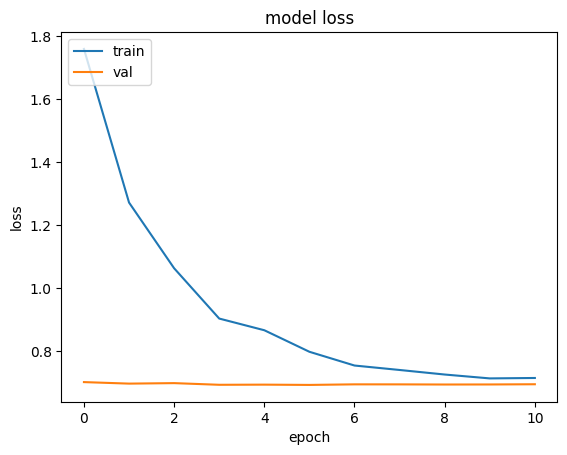

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

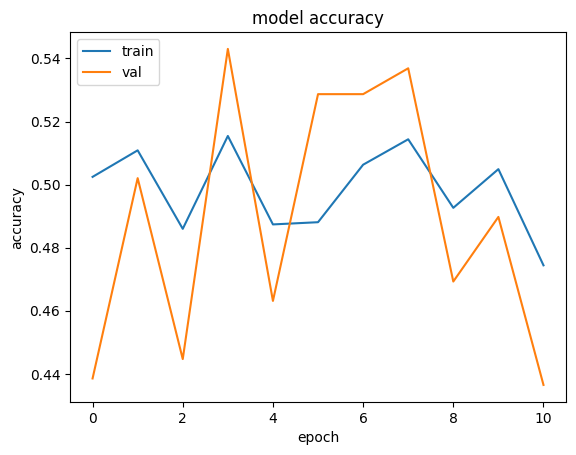

In [24]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

### Saving the model


In [14]:
MODEL_SAVE_PATH = f"./models/{TICKER_TO_PREDICT}_lg_{TRAIN_DATA_END_DATE.strftime('%Y%m%d')}/"
MODEL_SAVE_PATH

'./models/SPY_lg_20230830/'

In [26]:
model.save(MODEL_SAVE_PATH)

INFO:tensorflow:Assets written to: ./models/SPY_lg_20230830/assets


INFO:tensorflow:Assets written to: ./models/SPY_lg_20230830/assets


### Loading in the model


In [15]:
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

## Evaluating the model


### Confusion Matrix


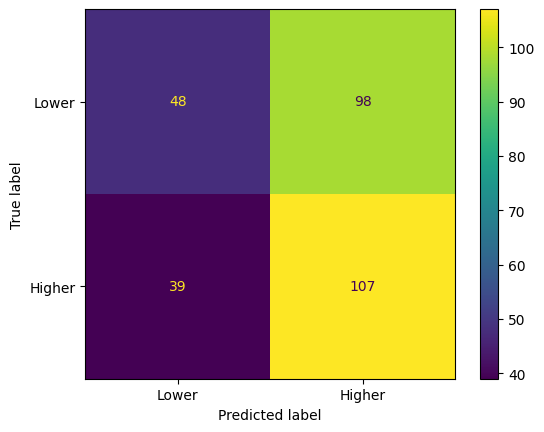

In [16]:
logits = model(X_test, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
cf_matrix = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cf_matrix, display_labels=["Lower", "Higher"])
cm_display.plot()
plt.show()

### Precision and Recall


In [17]:
logits = model(X_test, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
print(classification_report(y_test, predictions, target_names=["Lower", "Higher"]))

              precision    recall  f1-score   support

       Lower       0.55      0.33      0.41       146
      Higher       0.52      0.73      0.61       146

    accuracy                           0.53       292
   macro avg       0.54      0.53      0.51       292
weighted avg       0.54      0.53      0.51       292



### Testing on the test dataset


In [18]:
logits = model(X_test, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
test_accuracy = tf.keras.metrics.Accuracy()
test_accuracy(predictions, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5308219>

### Testing on the entire dataset


In [19]:
X, y = preprocess_df(df)

logits = model(X, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
test_accuracy = tf.keras.metrics.Accuracy()
test_accuracy(predictions, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.53908217>

### Testing on various stock tickers (within the S&P500)


In [20]:
def test_ticker(TICKER):
    df = yf.download(TICKER, progress=False)
    df.drop(columns=["Adj Close"], inplace=True)
    df.rename(columns={col: f"{TICKER}_{col}" for col in df.columns}, inplace=True)

    df[f"{TICKER}_Close_RSI"] = RSIIndicator(df[f"{TICKER}_Close"], window=14).rsi()
    df.dropna(inplace=True)

    for ticker in INDICATOR_TICKERS:
        ticker_data = yf.download(ticker, progress=False)
        relevant_data = ticker_data[RELEVANT_COLS]
        relevant_data = relevant_data.rename(
            columns={col: f"{ticker}_{col}" for col in RELEVANT_COLS}
        )
        # Only join if the columns aren't already present
        if len(set(df.columns).intersection(set(relevant_data.columns))) == 0:
            df = df.join(relevant_data)

    df.dropna(inplace=True)

    df[f"{TICKER}_Close_Future"] = df[f"{TICKER}_Close"].shift(
        -1 * PREDICTION_PERIOD_OFFSET
    )
    df.dropna(inplace=True)
    df["Target"] = list(
        map(classify, df[f"{TICKER}_Close"], df[f"{TICKER}_Close_Future"])
    )

    X, y = preprocess_df(df, balance=False)

    print("Starting inference")
    start = time.time()
    logits = model(X, training=False)
    print("End of inference")
    print(f"Inference took: {time.time() - start}s")
    predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
    test_accuracy = tf.keras.metrics.Accuracy()

    return test_accuracy(predictions, y)

In [21]:
test_ticker("AAPL")

Starting inference
End of inference
Inference took: 17.376892805099487s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5895101>

In [22]:
test_ticker("MSFT")

Starting inference
End of inference
Inference took: 17.816323041915894s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5869605>

In [23]:
test_ticker("V")

Starting inference
End of inference
Inference took: 9.201426029205322s


<tf.Tensor: shape=(), dtype=float32, numpy=0.61213136>

In [24]:
test_ticker("HD")

Starting inference
End of inference
Inference took: 17.352163314819336s


<tf.Tensor: shape=(), dtype=float32, numpy=0.55927885>

In [25]:
test_ticker("KO")

Starting inference
End of inference
Inference took: 16.924986362457275s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5445274>

In [26]:
test_ticker("JPM")

Starting inference
End of inference
Inference took: 17.603392601013184s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5554544>

### Testing on various stock tickers (not in the S&P500)


In [27]:
test_ticker("MC.PA")

Starting inference
End of inference
Inference took: 17.131781578063965s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5463424>

In [28]:
test_ticker("TTE")

Starting inference
End of inference
Inference took: 17.464688062667847s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5556365>

In [29]:
test_ticker("LIN")

Starting inference
End of inference
Inference took: 19.830444812774658s


<tf.Tensor: shape=(), dtype=float32, numpy=0.58659625>